In [1]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    ob1_files[i]=ob1_files[i].split('/')[-1].split('.')[0]
    patient=ob1_files[i].split('_')[0]
    sweep=ob1_files[i].split('sweep')[1]
    #if sweep[0] is not a number, use sweep[1]
    sweep = sweep[1] if not sweep[0].isdigit() else sweep[0]
    patient_t.append(patient)
    sweep_t.append(sweep)
print(ob1_files)
print(patient_t)
print(sweep_t)

['001_sweep1', '001_sweep2', '001_sweep3', '001_sweep4', '001_sweep5', '002_sweep1', '002_sweep2', '002_sweep3', '002_sweep5', '002_sweep6', '003_sweep1', '003_sweep2', '003_sweep3', '003_sweep4', '004_sweep1', '004_sweep2', '004_sweep4', '004_sweep5', '004_sweep6', '004_sweep7', '004_sweep8', '005_sweep1', '005_sweep2', '005_sweep3', '005_sweep4', '005_sweep5', '005_sweep6', '006_sweep1', '006_sweep4', '006_sweep5', '006_sweep6', '006_sweep7', '007_sweep1', '007_sweep2', '007_sweep3', '007_sweep4', '007_sweep6', '007_sweep7', '007_sweep8', '008_sweep1', '008_sweep2', '008_sweep3', '008_sweep6', '008_sweep7', '008_sweep8', '009_sweep1', '009_sweep2', '009_sweep3', '009_sweep4', '009_sweep5', '009_sweep6', '009_sweep7', '010_sweep1', '010_sweep2', '010_sweep3', '010_sweep4', '010_sweep6', '011_sweep1 (1)', '011_sweep1', '011_sweep2 (1)', '011_sweep2', '011_sweep3 (1)', '011_sweep3', '011_sweep4 (1)', '011_sweep4', '011_sweep5 (1)', '011_sweep5', '011_sweep6 (1)', '011_sweep6', '012_swee

In [2]:
import glob
import natsort
general_path = '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/'
ob1_files = glob.glob(general_path+'./LabelDataObstetrics/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
patient_t=[]
sweep_t=[]
for i in range(len(ob1_files)):
    sweep_t.append(ob1_files[i].split('/')[-1].split('.')[0])
    #check if ob1_files[i] has word copy, if so remove it
    if 'copy' in sweep_t[i]:
        sweep_t[i]=sweep_t[i].split(' copy')[0]
    patient=sweep_t[i][0:3]
    #if patient has letter _ in it, remove it and add a 0 start
    patient = '0'+patient if '_' in patient else patient
    patient=patient.split('_')[0]
    patient_t.append(patient)
print(ob1_files)
print(patient_t)
print(sweep_t)

['/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep1 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/002_sweep5 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/007_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep1 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/008_sweep7 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/010_sweep2 copy 2.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDataObstetrics/025_sweep4 copy.mat', '/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./LabelDa

In [3]:
print(len(ob1_files))

117


0


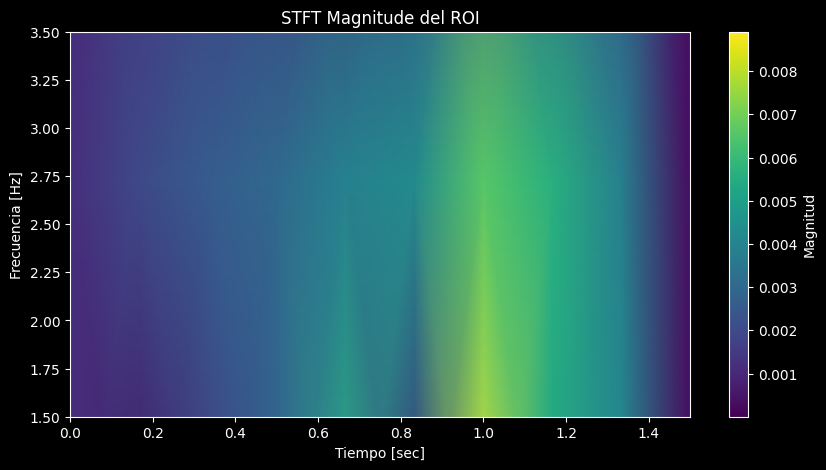

Frecuencia dominante: 2.73 Hz, equivalente a 163.6 BPM
1


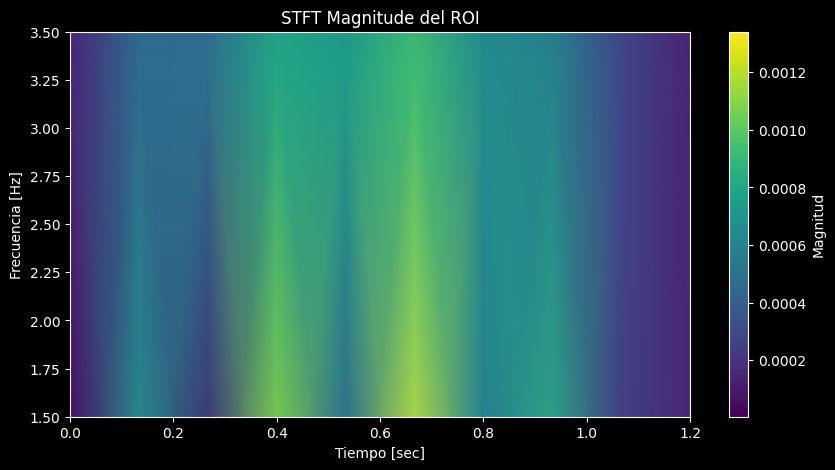

No se encontró una frecuencia dominante en la banda de interés.
2


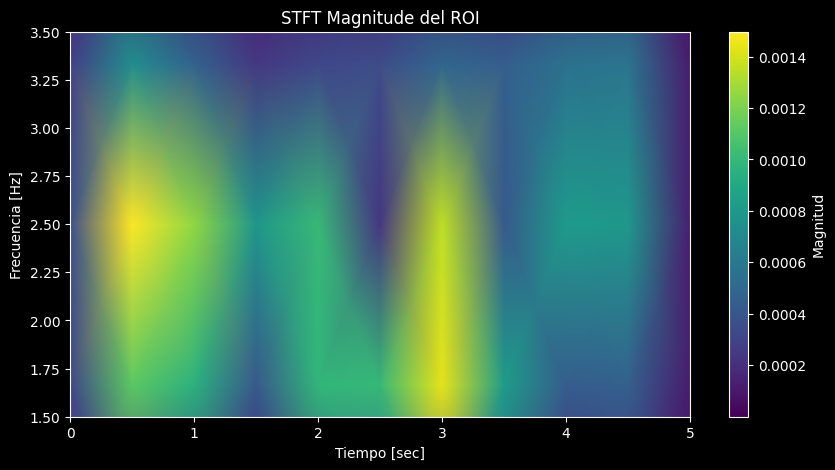

Frecuencia dominante: 2.50 Hz, equivalente a 150.0 BPM
3


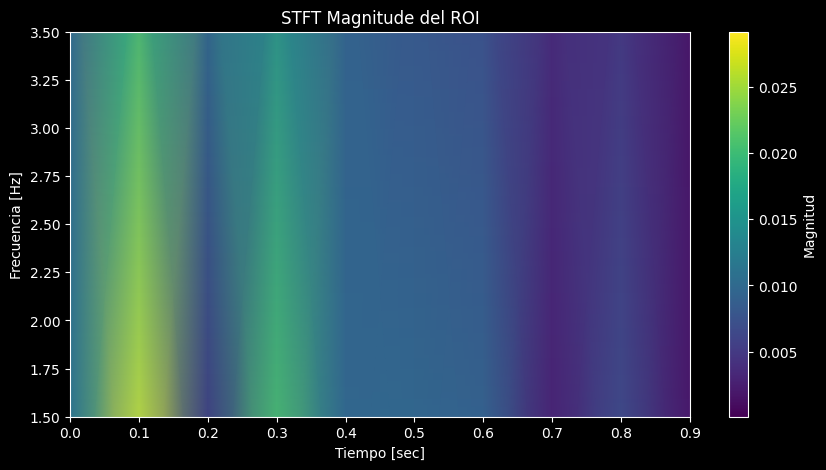

No se encontró una frecuencia dominante en la banda de interés.
4


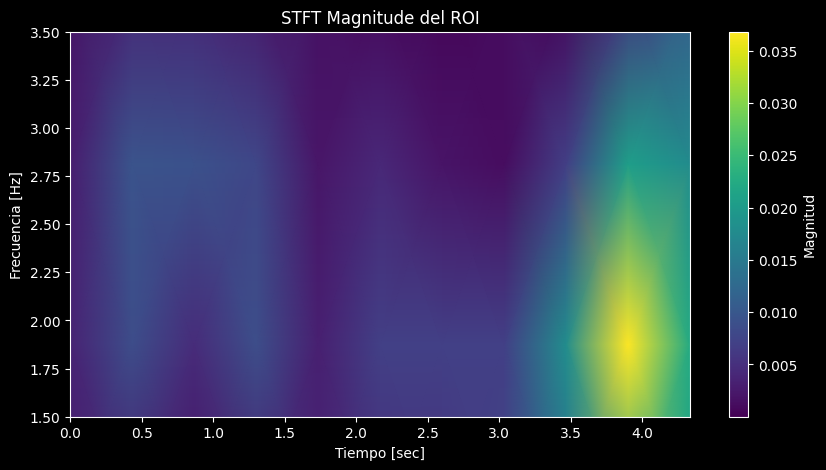

Frecuencia dominante: 1.88 Hz, equivalente a 112.5 BPM
5


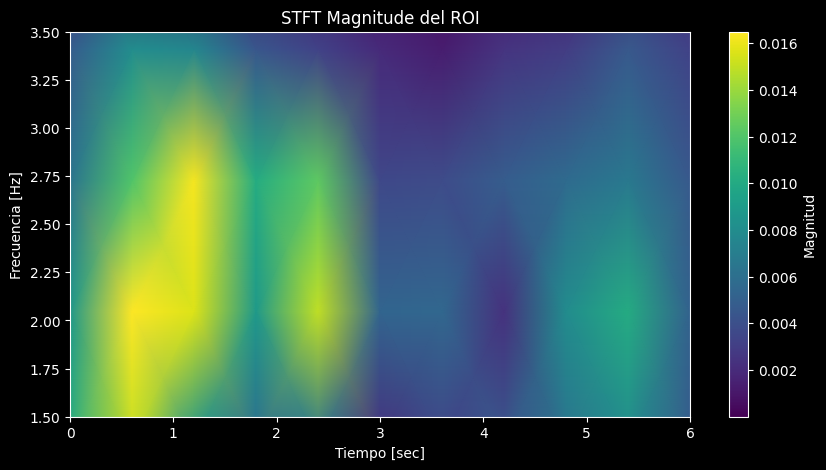

Frecuencia dominante: 2.05 Hz, equivalente a 122.7 BPM
6


ValueError: The length of the input vector x must be greater than padlen, which is 27.

In [ ]:

import cv2
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

from scipy.signal import stft, butter, filtfilt
src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video,generate_overlay_video_with_plot

# Opcional: Filtrado pasa banda para la banda de frecuencia cardíaca
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



#for i in range(0,len(ob1_files)):
for i in range(0,9):
    mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+sweep_t[i]+'.mp4'
    coordinates = sio.loadmat(general_path+'./crop_coordinates/'+patient_t[i]+'.mat')
    #substract 1 to coordinates to match python indexing
    x1 = coordinates['x1'][0][0]-1
    x2 = coordinates['x2'][0][0]
    y1 = coordinates['y1'][0][0]-1
    y2 = coordinates['y2'][0][0]

    width = x2-x1
    height = y2-y1

    ob = sio.loadmat(ob1_files[i])['labels']
    ob=np.moveaxis(ob, 2, 0)

    cap = cv2.VideoCapture(mp4_file_path)
    #join every frame as an array
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    gt_video = np.array(frames)

    # print(gt_video.shape)
    # print(ob.shape)
    # print('width: ',width)
    # print('height: ',height)
    diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
    diff_sum=np.sum(diff,axis=(1,2))
    #normalize diff_sum
    diff_sum = diff_sum/np.max(diff_sum)

    # Assuming diff_sum is your normalized data array from the plot
    # Example: diff_sum = np.array([...])  # Replace with your actual array
    threshold = 0.2

    # Detect indices where diff_sum crosses above the threshold
    first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
    last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

    #if from last_frame to the end is mask ob is not zero, last_frame is the last frame where mask is not zero
    for j in range(last_frame,diff.shape[0]):
        if np.sum(ob[j]) != 0:
            last_frame = j

    #if from start to first_frame is mask ob is not zero, first_frame is the first frame where mask is not zero
    #in this case the for is in reverse
    for j in range(first_frame,0,-1):
        if np.sum(ob[j]) != 0:
            first_frame = j


    # Obtener los límites del área de interés
    # row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    # y1, y2 = row_limits.min(), row_limits.max()
    # x1, x2 = col_limits.min(), col_limits.max()

    #check first if ob shape is the same as gt_video

    if ob.shape[1] != gt_video.shape[1] or ob.shape[2] != gt_video.shape[2]:
        #check width with ob.shape[2] and height with ob.shape[1]
        if width != ob.shape[2] or height != ob.shape[1]:
            # print('width and height are not the same')
            # print('width: ',width)
            # print('height: ',height)
            # print('gt: ', gt_video.shape)
            # print('ob: ',ob.shape)
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]
            #calculate padding or cropping for height (dim 1)
            pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
            pad_h_before = max(0, pad_or_crop_h // 2)
            pad_h_after = max(0, pad_or_crop_h - pad_h_before)
            crop_h_before = max(0, -pad_or_crop_h // 2)
            crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

            #calculate padding or cropping for width (dim 2)
            pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
            pad_w_before = max(0, pad_or_crop_w // 2)
            pad_w_after = max(0, pad_or_crop_w - pad_w_before)
            crop_w_before = max(0, -pad_or_crop_w // 2)
            crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

            #apply padding if needed
            if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
                ob = np.pad(ob, 
                                ((0, 0), 
                                (pad_h_before, pad_h_after), 
                                (pad_w_before, pad_w_after)), 
                                'constant')
                
            #apply cropping if needed
            if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
                ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

            

        else:
            # Recortar el área de interés
            gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
            ob = ob[first_frame:last_frame, :,:]

    else:
        # Recortar el área de interés
        gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
        ob = ob[first_frame:last_frame, y1:y2,x1:x2]

    non_empty_frames = np.where(np.any(ob > 0, axis=(1, 2)))[0]
    ob=ob[non_empty_frames]
    gt_video=gt_video[non_empty_frames]

    resultant=(ob > 0).astype(int)*gt_video

    intensities = np.sum(gt_video>0, axis=(1, 2))
    #normalizing intensities
    intensities = intensities/np.max(intensities)
    intensity_local = np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))


    num_classes = 2  # Número de clases
    # Crear la versión one-hot encoded
    one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
    # Verificar el nuevo shape
    # print(one_hot.shape) 
    #generate_overlay_video_with_plot(gt_video, one_hot,intensities,intensity_local, fps=30, output_video=general_path+'data/freq/'+sweep_t[i]+'_overlay.avi',gt_w=True)
    
    print(i)

    # Extraer la señal 1D del ROI: por ejemplo, la intensidad media de cada frame
    #signal = gt_video.mean(axis=(1,2))
    signal=np.sum(resultant>0, axis=(1, 2))/np.sum(ob>0, axis=(1, 2))
    #delete dc component
    signal = signal - np.mean(signal)


    # Parámetros de muestreo (por ejemplo, 30 fps)
    fs = 30

    # Por ejemplo, filtramos entre 0.8 y 2.5 Hz (48 - 180 BPM)
    lowcut = 1.5
    highcut = 3
    filtered_signal = bandpass_filter(signal, lowcut, highcut, fs)

    # Aplicamos la STFT a la señal filtrada
    f, t_stft, Zxx = stft(filtered_signal, fs=fs, nperseg=signal.shape[0]*0.25, noverlap=signal.shape[0]*0.15)

    # Calculamos la magnitud del espectrograma
    spectrogram = np.abs(Zxx)

    # Visualización del espectrograma
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t_stft, f, spectrogram, shading='gouraud')
    plt.title('STFT Magnitude del ROI')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [sec]')
    plt.colorbar(label='Magnitud')
    plt.ylim(1.5, 3.5)  # Limitar el eje de frecuencia para ver la banda de interés
    plt.show()

    # Estimar la frecuencia dominante a lo largo del tiempo (por ejemplo, promediando el espectrograma)
    mean_spectrum = np.mean(spectrogram, axis=1)
    indices_band = np.where((f >= lowcut) & (f <= highcut))[0]
    if indices_band.size > 0:
        idx_peak = indices_band[np.argmax(mean_spectrum[indices_band])]
        dominant_freq = f[idx_peak]
        bpm = dominant_freq * 60
        print(f"Frecuencia dominante: {dominant_freq:.2f} Hz, equivalente a {bpm:.1f} BPM")
    else:
        print("No se encontró una frecuencia dominante en la banda de interés.")
    break


In [5]:
import cv2
import numpy as np

# Suponiendo que gt_video ya ha sido preprocesado y tiene la forma (num_frames, height, width)
# Asegúrate de que las imágenes estén en formato uint8 para calcOpticalFlowFarneback.
gt_video_uint8 = resultant.astype(np.uint8)

# Lista para almacenar las imágenes de flujo óptico visualizadas
optical_flow_vis = []

# El primer frame se usará como frame inicial
prev_frame = gt_video_uint8[0]

# Iteramos sobre los frames, calculando el flujo entre el frame anterior y el actual
for i in range(1, len(gt_video_uint8)):
    curr_frame = gt_video_uint8[i]
    
    # Calcula el flujo óptico entre prev_frame y curr_frame
    flow = cv2.calcOpticalFlowFarneback(prev_frame, curr_frame, None,
                                        pyr_scale=0.5, levels=3, winsize=15,
                                        iterations=3, poly_n=5, poly_sigma=1.2, flags=0)
    
    # Separa el flujo en componentes x e y y calcula la magnitud y el ángulo
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    
    # Crea una imagen HSV para visualizar el flujo:
    # - Hue (tono) representa la dirección del flujo.
    # - Saturation se fija en 255.
    # - Value representa la magnitud del flujo (normalizada).
    hsv = np.zeros((prev_frame.shape[0], prev_frame.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2  # Convertir el ángulo a grados (en rango [0, 180])
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convierte la imagen HSV a BGR (para poder visualizarla con OpenCV)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    optical_flow_vis.append(rgb_flow)
    
    # Actualiza el frame anterior
    prev_frame = curr_frame

# Si deseas guardar el video del flujo óptico, puedes utilizar cv2.VideoWriter:
# Define el codec y crea el objeto VideoWriter.
fourcc = cv2.VideoWriter_fourcc(*'XVID')
altura, anchura = optical_flow_vis[0].shape[:2]
out = cv2.VideoWriter('optical_flow.avi', fourcc, 30.0, (anchura, altura))

for frame in optical_flow_vis:
    out.write(frame)
out.release()

print("Video de flujo óptico guardado como 'optical_flow.avi'")


Video de flujo óptico guardado como 'optical_flow.avi'


In [10]:
print(resultant.dtype)

int64


In [11]:
import cv2 as cv
import numpy as np

# Supongamos que gt_video es un arreglo NumPy de frames en escala de grises.
# Si no lo están, conviértelos a escala de grises.

# Parámetros para la detección de esquinas (Shi-Tomasi)
feature_params = dict(
    maxCorners=100,
    qualityLevel=0.3,
    minDistance=7,
    blockSize=7
)

# Parámetros para el cálculo de Lucas-Kanade Optical Flow
lk_params = dict(
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03)
)

# Generamos algunos colores aleatorios para dibujar las trayectorias
color = np.random.randint(0, 255, (100, 3))

# Tomamos el primer frame y detectamos esquinas en él
gt_video=resultant.astype(np.uint8)
old_gray = gt_video[0]
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Convertimos el primer frame a BGR para poder dibujar en color
old_frame_bgr = cv.cvtColor(old_gray, cv.COLOR_GRAY2BGR)

# Creamos una máscara para dibujar las trayectorias
mask = np.zeros_like(old_frame_bgr)

# Configuramos el VideoWriter para guardar el resultado
altura, anchura = old_frame_bgr.shape[:2]
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('lk_optical_flow.avi', fourcc, 30.0, (anchura, altura))

# Escribimos el primer frame en el video (sin dibujo aún)
out.write(old_frame_bgr)

# Recorremos los frames a partir del segundo
for i in range(1, len(gt_video)):
    frame_gray = gt_video[i]
    frame_bgr = cv.cvtColor(frame_gray, cv.COLOR_GRAY2BGR)
    
    # Calculamos el optical flow usando Lucas-Kanade
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Verificamos que se hayan obtenido nuevos puntos
    if p1 is None:
        print("No se pudieron rastrear puntos en el frame", i)
        break

    # Seleccionamos los puntos que se rastrearon correctamente
    good_new = p1[st == 1]
    good_old = p0[st == 1]

    # Dibujamos las trayectorias para cada punto
    for j, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), color[j].tolist(), 2)
        frame_bgr = cv.circle(frame_bgr, (int(a), int(b)), 5, color[j].tolist(), -1)

    # Combinamos el frame actual con la máscara para obtener la visualización final
    img = cv.add(frame_bgr, mask)
    
    # Escribimos el frame resultante en el video de salida
    out.write(img)
    
    # Actualizamos el frame anterior y los puntos para el siguiente cálculo
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

# Liberamos el VideoWriter y cerramos cualquier ventana (aunque en este caso no se abrieron)
out.release()
cv.destroyAllWindows()

print("El video con Lucas-Kanade Optical Flow se ha guardado como 'lk_optical_flow.avi'")


El video con Lucas-Kanade Optical Flow se ha guardado como 'lk_optical_flow.avi'


In [5]:

import cv2
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video


for i in range(0,len(ob1_files)):
# for i in range(2,3):
     mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+sweep_t[i]+'.mp4'
     coordinates = sio.loadmat(general_path+'./crop_coordinates/'+patient_t[i]+'.mat')
     #substract 1 to coordinates to match python indexing
     x1 = coordinates['x1'][0][0]-1
     x2 = coordinates['x2'][0][0]
     y1 = coordinates['y1'][0][0]-1
     y2 = coordinates['y2'][0][0]

     width = x2-x1
     height = y2-y1

     ob = sio.loadmat(ob1_files[i])['labels']
     ob=np.moveaxis(ob, 2, 0)

     cap = cv2.VideoCapture(mp4_file_path)
     #join every frame as an array
     frames = []
     while True:
          ret, frame = cap.read()
          if not ret:
               break
          frames.append(frame)
     cap.release()
     gt_video = np.array(frames)

     # print(gt_video.shape)
     # print(ob.shape)
     # print('width: ',width)
     # print('height: ',height)
     diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
     diff_sum=np.sum(diff,axis=(1,2))
     #normalize diff_sum
     diff_sum = diff_sum/np.max(diff_sum)

     # Assuming diff_sum is your normalized data array from the plot
     # Example: diff_sum = np.array([...])  # Replace with your actual array
     threshold = 0.2

     # Detect indices where diff_sum crosses above the threshold
     first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
     last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

     #if from last_frame to the end is mask ob is not zero, last_frame is the last frame where mask is not zero
     for j in range(last_frame,diff.shape[0]):
          if np.sum(ob[j]) != 0:
               last_frame = j

     #if from start to first_frame is mask ob is not zero, first_frame is the first frame where mask is not zero
     #in this case the for is in reverse
     for j in range(first_frame,0,-1):
          if np.sum(ob[j]) != 0:
               first_frame = j


     # Obtener los límites del área de interés
     # row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
     # y1, y2 = row_limits.min(), row_limits.max()
     # x1, x2 = col_limits.min(), col_limits.max()
   
     #check first if ob shape is the same as gt_video
 
     if ob.shape[1] != gt_video.shape[1] or ob.shape[2] != gt_video.shape[2]:
          #check width with ob.shape[2] and height with ob.shape[1]
          if width != ob.shape[2] or height != ob.shape[1]:
               # print('width and height are not the same')
               # print('width: ',width)
               # print('height: ',height)
               # print('gt: ', gt_video.shape)
               # print('ob: ',ob.shape)
               gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
               ob = ob[first_frame:last_frame, :,:]
               #calculate padding or cropping for height (dim 1)
               pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
               pad_h_before = max(0, pad_or_crop_h // 2)
               pad_h_after = max(0, pad_or_crop_h - pad_h_before)
               crop_h_before = max(0, -pad_or_crop_h // 2)
               crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

               #calculate padding or cropping for width (dim 2)
               pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
               pad_w_before = max(0, pad_or_crop_w // 2)
               pad_w_after = max(0, pad_or_crop_w - pad_w_before)
               crop_w_before = max(0, -pad_or_crop_w // 2)
               crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

               #apply padding if needed
               if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
                    ob = np.pad(ob, 
                                 ((0, 0), 
                                 (pad_h_before, pad_h_after), 
                                 (pad_w_before, pad_w_after)), 
                                 'constant')
                    
               #apply cropping if needed
               if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
                    ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

               

          else:
               # Recortar el área de interés
               gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
               ob = ob[first_frame:last_frame, :,:]

     else:
          # Recortar el área de interés
          gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
          ob = ob[first_frame:last_frame, y1:y2,x1:x2]

     subject = tio.Subject(
     video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
     label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
     )

     num_classes = 2  # Número de clases
     # Crear la versión one-hot encoded
     one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
     # Verificar el nuevo shape
     # print(one_hot.shape) 
     generate_overlay_video(gt_video, one_hot, fps=30, output_video=general_path+'data/maddie_vid/'+sweep_t[i]+'_overlay.avi',gt_w=True)
     
     #efine the resize transform
     resize_transform = tio.transforms.Resize((128,128,128))  # New shape: [frames, width, height]

     # Apply the resize transform to the subject
     resized_subject = resize_transform(subject)

     # Extract resized video GT and label from the subject
     resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
     resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

     #save the label with ground truth in npz format
     #np.savez_compressed(general_path+'data/'+patient_t[i]+'_sweep'+sweep_t[i]+'.npz', video=resized_video_gt, label=resized_label.astype(np.uint8))
     #save with np.save as npy gt and label
     np.save(general_path+'data/128x128x128_maddie/'+sweep_t[i]+'_gt.npy', resized_video_gt)
     np.save(general_path+'data/128x128x128_maddie/'+sweep_t[i]+'_label.npy', resized_label.astype(np.uint8))

     print(i)

Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/002_sweep1_overlay.avi
0
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/002_sweep4_overlay.avi
1
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/002_sweep5_overlay.avi
2
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/007_sweep1_overlay.avi
3
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/008_sweep1_overlay.avi
4
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/008_sweep7_overlay.avi
5
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/maddie_vid/010_sweep2_overlay.avi
6
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/d

In [4]:
ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
#split ob1_files.split('/')
ob1_files=[i.split('/')[-1].split('.')[0] for i in ob1_files]
npy_files = glob.glob(general_path+'./data/128x128x128/*.npy')
npy_files = natsort.natsorted(npy_files)
npy_files=list(set([i.split('/')[-1].split('.')[0].split('_gt')[0].split('_label')[0] for i in npy_files]))
print(npy_files)
print(len(ob1_files))
print(len(npy_files))
#find the difference between the two lists
diff = list(set(npy_files) - set(ob1_files))
print(diff)


['002_sweep1', '003_sweep3', '011_sweep1', '004_sweep5', '006_sweep7', '015_sweep2', '008_sweep7', '009_sweep6', '002_sweep6', '015_sweep4', '001_sweep4', '008_sweep2', '013_sweep7', '007_sweep7', '009_sweep4', '008_sweep3', '013_sweep5', '014_sweep4', '016_sweep7', '011_sweep2', '009_sweep7', '015_sweep5', '002_sweep5', '005_sweep5', '015_sweep1', '014_sweep8', '013_sweep2', '007_sweep4', '001_sweep3', '007_sweep6', '007_sweep8', '004_sweep4', '011_sweep4', '012_sweep6', '013_sweep3', '004_sweep7', '005_sweep3', '009_sweep5', '013_sweep1', '014_sweep3', '009_sweep2', '005_sweep1', '016_sweep6', '012_sweep1', '002_sweep2', '013_sweep6', '011_sweep6', '001_sweep1', '005_sweep6', '004_sweep2', '016_sweep2', '006_sweep4', '001_sweep2', '005_sweep2', '014_sweep7', '014_sweep6', '016_sweep1', '008_sweep6', '011_sweep3', '007_sweep3', '014_sweep5', '011_sweep5', '014_sweep2', '014_sweep1', '010_sweep1', '004_sweep1', '005_sweep4', '012_sweep3', '016_sweep4', '007_sweep1', '004_sweep8', '006_

In [ ]:


import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph
import cv2

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)

for i in range(4,len(ob1_files)):
# for i in range(2,3):
     mp4_file_path = general_path+'./Study/'+patient_t[i]+'/'+patient_t[i]+'_sweep'+sweep_t[i]+'.mp4'
     print(mp4_file_path)
     coordinates = sio.loadmat(general_path+'./crop_coordinates/'+patient_t[i]+'.mat')
     #substract 1 to coordinates to match python indexing
     x1 = coordinates['x1'][0][0]-1
     x2 = coordinates['x2'][0][0]
     y1 = coordinates['y1'][0][0]-1
     y2 = coordinates['y2'][0][0]

     width = x2-x1
     height = y2-y1

     ob = sio.loadmat(ob1_files[i])['labels']
     ob=np.moveaxis(ob, 2, 0)

     cap = cv2.VideoCapture(mp4_file_path)
     #join every frame as an array
     frames = []
     while True:
          ret, frame = cap.read()
          if not ret:
               break
          frames.append(frame)
     cap.release()
     gt_video = np.array(frames)

     # print(gt_video.shape)
     # print(ob.shape)
     # print('width: ',width)
     # print('height: ',height)
     diff = gt_video[1:,:,:,0]-gt_video[:-1,:,:,0]
     diff_sum=np.sum(diff,axis=(1,2))
     #normalize diff_sum
     diff_sum = diff_sum/np.max(diff_sum)

     # Assuming diff_sum is your normalized data array from the plot
     # Example: diff_sum = np.array([...])  # Replace with your actual array
     threshold = 0.2

     # Detect indices where diff_sum crosses above the threshold
     first_frame = np.where(diff_sum > threshold)[0][0]  # First upward crossing
     last_frame = np.where(diff_sum > threshold)[0][-1]  # Last upward crossing (before drop)

     #if from last_frame to the end is mask ob is not zero, last_frame is the last frame where mask is not zero
     for j in range(last_frame,diff.shape[0]):
          if np.sum(ob[j]) != 0:
               last_frame = j

     #if from start to first_frame is mask ob is not zero, first_frame is the first frame where mask is not zero
     #in this case the for is in reverse
     for j in range(first_frame,0,-1):
          if np.sum(ob[j]) != 0:
               first_frame = j


     # Obtener los límites del área de interés
     # row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
     # y1, y2 = row_limits.min(), row_limits.max()
     # x1, x2 = col_limits.min(), col_limits.max()
   
     #check first if ob shape is the same as gt_video
 
     if ob.shape[1] != gt_video.shape[1] or ob.shape[2] != gt_video.shape[2]:
          #check width with ob.shape[2] and height with ob.shape[1]
          if width != ob.shape[2] or height != ob.shape[1]:
               # print('width and height are not the same')
               # print('width: ',width)
               # print('height: ',height)
               # print('gt: ', gt_video.shape)
               # print('ob: ',ob.shape)
               gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
               ob = ob[first_frame:last_frame, :,:]
               #calculate padding or cropping for height (dim 1)
               pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
               pad_h_before = max(0, pad_or_crop_h // 2)
               pad_h_after = max(0, pad_or_crop_h - pad_h_before)
               crop_h_before = max(0, -pad_or_crop_h // 2)
               crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

               #calculate padding or cropping for width (dim 2)
               pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
               pad_w_before = max(0, pad_or_crop_w // 2)
               pad_w_after = max(0, pad_or_crop_w - pad_w_before)
               crop_w_before = max(0, -pad_or_crop_w // 2)
               crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

               #apply padding if needed
               if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
                    ob = np.pad(ob, 
                                 ((0, 0), 
                                 (pad_h_before, pad_h_after), 
                                 (pad_w_before, pad_w_after)), 
                                 'constant')
                    
               #apply cropping if needed
               if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
                    ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

               

          else:
               # Recortar el área de interés
               gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
               ob = ob[first_frame:last_frame, :,:]

     else:
          # Recortar el área de interés
          gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
          ob = ob[first_frame:last_frame, y1:y2,x1:x2]

     subject = tio.Subject(
     video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
     label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
     )
     num_classes = 6  # Número de clases
     # Crear la versión one-hot encoded
     one_hot = np.eye(num_classes)[ob]  # Esto genera el one-hot encoding
     # Verificar el nuevo shape
     # print(one_hot.shape) 
     generate_overlay_video(gt_video, one_hot, fps=30, output_video=general_path+'data/marika_vid/'+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)
     #generate_overlay_video(gt_video, one_hot, fps=30, output_video=general_path+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)
     

#      #save the label with ground truth in npz format
#      #np.savez_compressed(general_path+'data/'+patient_t[i]+'_sweep'+sweep_t[i]+'.npz', video=resized_video_gt, label=resized_label.astype(np.uint8))
     
#      #efine the resize transform
#      resize_transform = tio.transforms.Resize((128,128,128))  # New shape: [frames, width, height]

#      # Apply the resize transform to the subject
#      resized_subject = resize_transform(subject)

#      # Extract resized video GT and label from the subject
#      resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
#      resized_label = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label
#      #one_hot = np.eye(num_classes)[resized_label]  # Esto genera el one-hot encodingy_video(resized_video_gt, one_hot, fps=30, output_video=general_path+'data/128x128x128'+patient_t[i]+'_sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)
     
#      #generate_overlay_video(resized_video_gt, one_hot, fps=30, output_video=general_path+patient_t[i]+'_128sweep'+sweep_t[i]+'_overlay.avi',gt_w=True)

#   #save with np.save as npy gt and label
#      np.save(general_path+'data/128x128x128/'+patient_t[i]+'_sweep'+sweep_t[i]+'_gt.npy', resized_video_gt)
#      np.save(general_path+'data/128x128x128/'+patient_t[i]+'_sweep'+sweep_t[i]+'_label.npy', resized_label.astype(np.uint8))
     
     print(i)

/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep5.mp4
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/marika_vid/001_sweep5_overlay.avi
4
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep1.mp4
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/marika_vid/002_sweep1_overlay.avi
5
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep2.mp4
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/marika_vid/002_sweep2_overlay.avi
6
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep3.mp4
Video guardado como /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/data/marika_vid/002_sweep3_overlay.avi
7
/Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/002/002_sweep5.mp4


In [56]:
import numpy as np
import scipy.io as sio
import skvideo.io as skv
import torchio as tio
from skimage.transform import resize
import os
import sys
import matplotlib.pyplot as plt
import skimage.morphology as morph

src_path = os.path.join(general_path, 'src')
sys.path.append(src_path)

#import overlay_video from src/utils/overlay_video.py assuming that the file is in the same directory
from utils.overlay_video import generate_overlay_video

ob1_files = glob.glob(general_path+'./LabelDataObstetrics1/*.mat')
ob1_files = natsort.natsorted(ob1_files)
from collections import Counter

# Inicializar contador para las clases
class_counts = Counter()
total_pixels = 0  # Contador total de píxeles

for i in range(len(ob1_files)):  # Iterar sobre todos los videos
#for i in range(81,82):
    mp4_file_path = general_path + './Study/' + patient_t[i] + '/' + patient_t[i] + '_sweep' + sweep_t[i] + '.mp4'
    print(f"Procesando: {mp4_file_path}")
    
    # Cargar etiquetas y video
    ob = sio.loadmat(ob1_files[i])['labels']
    ob = np.moveaxis(ob, 2, 0)
    gt_video = skv.vread(mp4_file_path)
    
    # Calcular diferencias de frames y extraer área de interés
    diff = gt_video[1:, :, :, 0] - gt_video[:-1, :, :, 0]
    diff_sum = np.sum(diff, axis=(1, 2)) / np.max(np.sum(diff, axis=(1, 2)))  # Normalizar
    
    # Detectar frames inicial y final
    threshold = 0.2
    first_frame = np.where(diff_sum > threshold)[0][0]
    last_frame = np.where(diff_sum > threshold)[0][-1]
    
    # Recortar video y etiquetas
    row_limits, col_limits = np.where(morph.remove_small_objects(diff[first_frame+50].astype(bool), min_size=100) > 0)
    y1, y2 = row_limits.min(), row_limits.max()
    x1, x2 = col_limits.min(), col_limits.max()
    gt_video = gt_video[first_frame:last_frame, y1:y2, x1:x2, 0]
    ob = ob[first_frame:last_frame, :, :]
    
    # Asegurar que dimensiones coincidan
    if gt_video.shape[1] != ob.shape[1] or gt_video.shape[2] != ob.shape[2]:
        pad_or_crop_h = (gt_video.shape[1] - ob.shape[1])
        pad_h_before = max(0, pad_or_crop_h // 2)
        pad_h_after = max(0, pad_or_crop_h - pad_h_before)
        crop_h_before = max(0, -pad_or_crop_h // 2)
        crop_h_after = max(0, -pad_or_crop_h - crop_h_before)

        pad_or_crop_w = (gt_video.shape[2] - ob.shape[2])
        pad_w_before = max(0, pad_or_crop_w // 2)
        pad_w_after = max(0, pad_or_crop_w - pad_w_before)
        crop_w_before = max(0, -pad_or_crop_w // 2)
        crop_w_after = max(0, -pad_or_crop_w - crop_w_before)

        if pad_h_before > 0 or pad_h_after > 0 or pad_w_before > 0 or pad_w_after > 0:
            ob = np.pad(ob, 
                        ((0, 0), 
                         (pad_h_before, pad_h_after), 
                         (pad_w_before, pad_w_after)), 
                        'constant')

        if crop_h_before > 0 or crop_h_after > 0 or crop_w_before > 0 or crop_w_after > 0:
            ob = ob[:, crop_h_before:ob.shape[1] - crop_h_after, crop_w_before:ob.shape[2] - crop_w_after]

    # Now, `ob` will have the same shape as `gt_video`
    # Create a TorchIO subject with paired data
    subject = tio.Subject(
    video_gt=tio.ScalarImage(tensor=np.expand_dims(gt_video,axis=0)),  # Add channel dimension
    label=tio.LabelMap(tensor=np.expand_dims(ob,axis=0))  # Add channel dimension
    )

    #efine the resize transform
    resize_transform = tio.transforms.Resize((256,512,512))  # New shape: [frames, width, height]

    # Apply the resize transform to the subject
    resized_subject = resize_transform(subject)

    # Extract resized video GT and label from the subject
    resized_video_gt = resized_subject.video_gt.tensor.squeeze(0).numpy()  # Remove channel dimension
    ob = resized_subject.label.tensor.squeeze(0).numpy().astype(int)  # Ensure integers for label

    # Contar píxeles de cada clase en las etiquetas
    ob_flat = ob.flatten()  # Aplana las etiquetas
    class_counts.update(ob_flat.tolist())  # Contar píxeles por clase
    total_pixels += ob_flat.size  # Incrementar el conteo total de píxeles

# Mostrar conteos finales
print(f"Conteo total de píxeles: {total_pixels}")
print(f"Conteos por clase: {class_counts}")


# Calcular frecuencias relativas
num_classes = max(class_counts.keys()) + 1  # Determina el número de clases
freqs = [class_counts[i] / total_pixels if i in class_counts else 0 for i in range(num_classes)]
print(f"Frecuencia relativa de clases: {freqs}")

# Calcular pesos inversos
inverse_weights = [1 / f if f > 0 else 0 for f in freqs]
total_weight = sum(inverse_weights)
alpha = [w / total_weight for w in inverse_weights]  # Normalizar
print(f"Pesos inversos normalizados (alpha): {alpha}")


Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep1.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep2.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep3.mp4
Procesando: /Users/emilio/Library/CloudStorage/Box-Box/GitHub/lightning-template/./Study/001/001_sweep4.mp4


KeyboardInterrupt: 